In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
import torch
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

import json
import os
import pickle
from pathlib import Path
import optuna
import wandb

In [16]:
params = {
    "pgf.texsystem": "xelatex",
    "pgf.rcfonts": False,
    "font.serif": [],
    "font.family": "serif",
    "font.sans-serif": [],
    "axes.labelsize": 11,
}
plt.rcParams.update(params)
rc("text", usetex=True)

CM = 1 / 2.54
cmap = plt.cm.get_cmap("viridis")

# plt.style.use(['science','nature'])

# Bright color scheme
# color-blind safe
# from Paul Tot's website: https://personal.sron.nl/~pault/
# Set color cycle
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', ['4477AA', 'EE6677', '228833', 'CCBB44', '66CCEE', 'AA3377', 'BBBBBB'])


# Standard SciencePlots color cycle
mpl.rcParams["axes.prop_cycle"] = mpl.cycler(
    "color", ["0C5DA5", "00B945", "FF9500", "FF2C00", "845B97", "474747", "9e9e9e"]
)


In [3]:
# results_df = pd.read_csv("../data/results/learning_curves_gbm_default_params.csv")
# train_sizes = results_df.start.abs().unique()
# train_acc_uni = results_df[results_df.strategy == "uniform"].train_acc
# val_acc_uni = results_df[results_df.strategy == "uniform"].val_acc

# train_acc_exp = results_df[results_df.strategy == "exponential"].train_acc
# val_acc_exp = results_df[results_df.strategy == "exponential"].val_acc


In [4]:
# # fig, axs = plt.subplot_mosaic("AB;CD", figsize=(10,10))

# fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12*CM, 6*CM), sharey=True, sharex=True, constrained_layout=True)

# ax1.plot(train_sizes, train_acc_uni, ".-", label="Train", color="C1")
# ax1.plot(train_sizes, val_acc_uni, ".-", label="Val", color="C0")


# ax2.plot(train_sizes, train_acc_exp, ".-", label="Train", color="C1")
# ax2.plot(train_sizes, val_acc_exp, ".-", label="Val", color="C0")

# # if not ax:
# #     ax=plt.gca()

# # ax.fill_between(
# #         train_sizes,
# #         train_acc + 0.02, # .mean(axis=1) - fit_times.std(axis=1),
# #         train_acc - 0.02, # fit_times.mean(axis=1) + fit_times.std(axis=1),
# #         alpha=0.3,
# #         color="C3",
# # )

# # ax.fill_between(
# #         train_sizes,
# #         val_acc + 0.02, # .mean(axis=1) - fit_times.std(axis=1),
# #         val_acc - 0.02, # fit_times.mean(axis=1) + fit_times.std(axis=1),
# #         alpha=0.3,
# # )

# # max
# xmax = train_sizes[np.argmax(val_acc_uni)]
# ymax = val_acc_uni.max()
# ax1.plot(xmax, ymax, ".", color="C3")
# ax1.text(xmax, ymax + 0.02, f"{ymax * 100 :.2f}\%",         horizontalalignment='center')
# #ax1.axvline(x=xmax, color="black", linestyle="--", linewidth=0.5)

# xmax = train_sizes[np.argmax(val_acc_exp)]
# ymax = val_acc_exp.max()
# ax2.plot(xmax, ymax, ".", color="C3")
# ax2.text(xmax, ymax + 0.02, f"{ymax * 100 :.2f}\%",         horizontalalignment='center')
# #ax2.axvline(x=xmax, color="black", linestyle="--", linewidth=0.5)

# ax2.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=2))
# ax2.xaxis.set_major_formatter(ticker.EngFormatter())
# # title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
# # plt.title(title, fontsize = 18, y = 1.03)
# ax1.legend(loc="lower right", frameon=False)
# ax2.legend(loc="lower right", frameon=False)
# plt.ylim(0.6, 1)
# # plt.show()

# ax1.set_title('(a) Uniform Weights')
# ax2.set_title('(b) Exponential Weights')
# # plt.tight_layout()
# # plt.ylabel("Accuracy")  # , fontsize = "small")
# # plt.xlabel("Number of Training Samples")  # , fontsize = "small")

# fig.supylabel('Accuracy')
# fig.supxlabel('Number of Training Samples')

# plt.savefig(
#     f"../reports/Graphs/learning-curves-gradient-boosting.pdf",
#     bbox_inches="tight",
# )


In [5]:
# feature_importance_adv_val = pd.read_csv("../data/results/feature_importance_gbm_classical_size.csv")
# # feature_importance_adv_val.set_index("Feature Id", drop=True, inplace=True)
# # feature_importance_adv_val.drop(columns=["Unnamed: 0"], inplace=True)

In [6]:
# feature_importance_adv_val["Feature Id"] = feature_importance_adv_val["Feature Id"].str.lower()

In [7]:
# # feature_importance_adv_val.plot.bar(figsize=(12 * CM, 6 * CM))
# ax = feature_importance_adv_val.plot.bar(x='Feature Id', y='Importances', figsize=(12 * CM, 6 * CM))
# ax.set_ylabel("Feature Importance in \%")
# ax.set_xlabel("Feature")
# # ax.set_major_formatter(ticker.PercentFormatter(xmax=100, decimals=0))
# plt.legend(frameon=False)
# plt.savefig(
#     f"../reports/Graphs/adv-val-gradient-boosting.pdf",
#     bbox_inches="tight",
# )

In [3]:
def to_mpl(start: str, end: str):
    mpl_start = mdates.date2num(pd.to_datetime(start))
    mpl_end = mdates.date2num(pd.to_datetime(end))
    return mpl_start, mpl_end - mpl_start


In [4]:
def to_pos(span: tuple):
    return span[0] + 0.5 * span[1]


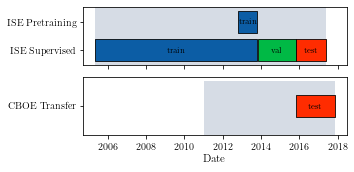

In [17]:
fig, (ax, bx) = plt.subplots(
    2, 1, sharey="none", sharex="col", figsize=(12 * CM, 6 * CM)
)

# ise
ax.broken_barh([to_mpl("2005-05-02", "2017-05-31")], (1, 5), facecolors="#D6DCE5")

# ise pretraining
span = [to_mpl("2012-10-23", "2013-10-24")]
ax.broken_barh(span, (2.5, 1), facecolors="C0", edgecolor="black", linewidth=0.8)

ax.text(
    x=to_pos(span[0]),
    y=3,
    s="train",
    ha="center",
    va="center",
    color="black",
    fontsize="small",
)

spans = [
    to_mpl("2005-05-02", "2013-10-24"),
    to_mpl("2013-10-25", "2015-11-05"),
    to_mpl("2015-11-06", "2017-05-31"),
]

# ise supervised
ax.broken_barh(
    spans,
    (1.2, 1),
    facecolors=("C0", "C1", "C3"),
    edgecolor="black",
    linewidth=0.8,
)

# add text labels manually
labels = ["train", "val", "test"]
for i, s in enumerate(spans):
    ax.text(
        x=to_pos(s),
        y=1.7,
        s=labels[i],
        ha="center",
        va="center",
        color="black",
        fontsize="small",
    )

ax.xaxis_date()
plt.setp(ax.get_xticklabels(), visible=True)

# cboe
bx.broken_barh([to_mpl("2011-01-01", "2017-10-31")], (1, 2.5), facecolors="#D6DCE5")

spans = [
    to_mpl("2015-11-06", "2017-10-31"),
]

# cboe supervised
bx.broken_barh(
    spans,
    (1.85, 1),
    facecolors=("C3"),
    edgecolor="black",
    linewidth=0.8,
)

# add text labels manually
labels = ["test"]
for i, s in enumerate(spans):
    bx.text(
        x=to_pos(s),
        y=2.35,
        s=labels[i],
        ha="center",
        va="center",
        color="black",
        fontsize="small",
    )



# Modify y-axis tick labels
ax.set_yticks([1.7, 3], labels=["ISE Supervised", "ISE Pretraining"])
bx.set_yticks([2.35], labels=["CBOE Transfer"])

ax.set_ylim(1, 3.7)
bx.set_ylim(1, 3.7)

# into to date
bx.xaxis_date()

plt.xlabel("Date")

# plt.show()
plt.savefig("../reports/Graphs/train-test-split.pdf", bbox_inches="tight")


In [11]:
print(plt.rcParams["axes.linewidth"])


0.8


In [18]:
# code from https://d2l.ai/d2l-en.pdf
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5), cmap=cmap):
    num_rows, num_cols, _, _ = matrices.shape
    fig, axes = plt.subplots(
        num_rows, num_cols, figsize=figsize, sharex=True, sharey=True, squeeze=False
    )
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes)
    plt.savefig("../reports/Graphs/attention-maps.pdf", bbox_inches="tight")


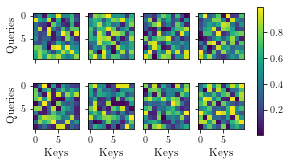

In [19]:
# attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
attention_weights = torch.rand(size=(2, 4, 10, 10))
show_heatmaps(
    attention_weights, xlabel="Keys", ylabel="Queries", figsize=(12 * CM, 6 * CM)
)


In [20]:
# Code from https://www.tensorflow.org/tutorials/text/transformer
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates


def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model
    )

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return pos_encoding


(1, 64, 96)


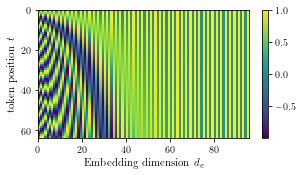

In [21]:
tokens = 64
dimensions = 96


pos_encoding = positional_encoding(tokens, dimensions)
print(pos_encoding.shape)

plt.figure(figsize=(12 * CM, 6 * CM))
plt.pcolormesh(pos_encoding[0], cmap=cmap)
plt.xlabel("Embedding dimension $d_e$")
plt.xlim((0, dimensions))
plt.ylim((tokens, 0))
plt.ylabel("token position $t$")
plt.colorbar()
plt.savefig("../reports/Graphs/positional-encoding.pdf", bbox_inches="tight")


## Gradient Boosting

In [16]:
# set study globally here
study = "fbv/thesis/xl3n4thc.optuna:v99"
model = "xl3n4thc_CatBoostClassifier_default.cbm:v9"

In [23]:
# see https://wandb.ai/fbv/thesis/runs/kwlaw02g/overview?workspace=user-karelze
run = wandb.init(project="thesis", entity="fbv")

study_name, version = study.split(":")

model_name = model.split("/")[-1].split(":")[0]
study_id = model_name.split("_")[0]

artifact = run.use_artifact(study)
study_dir = artifact.download()

artifact = run.use_artifact(model)
model_dir = artifact.download()

wandb:   1 of 1 files downloaded.  
wandb:   2 of 2 files downloaded.  


/scratch/slurm_tmpdir/job_21925995/ipykernel_622108/3571520286.py:5: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  param_importances = optuna.visualization.matplotlib.plot_param_importances(study);
/scratch/slurm_tmpdir/job_21925995/ipykernel_622108/3571520286.py:6: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  slices = optuna.visualization.matplotlib.plot_slice(study);
/scratch/slurm_tmpdir/job_21925995/ipykernel_622108/3571520286.py:7: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  contours = optuna.visualization.matplotlib.plot_contour(
[W 2023-03-15 19:18:19,911] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


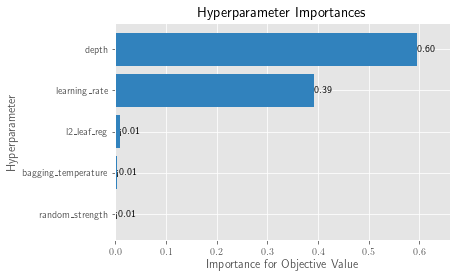

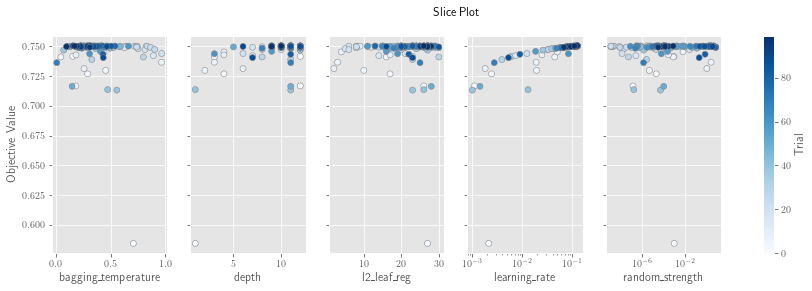

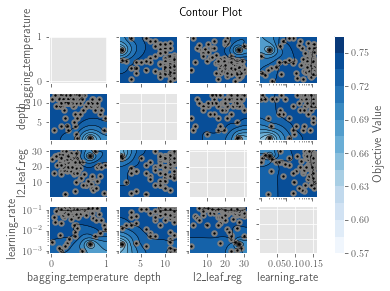

In [42]:
file  = open(f"./artifacts/{study_id}.optuna:{version}/{study_id}.optuna",'rb')
study = pickle.load(file)

#optuna.visualization.matplotlib.plot_optimization_history(study)
param_importances = optuna.visualization.matplotlib.plot_param_importances(study);
slices = optuna.visualization.matplotlib.plot_slice(study);
contours = optuna.visualization.matplotlib.plot_contour(
     study, ["learning_rate", "depth", "bagging_temperature", "l2_leaf_reg"]
);

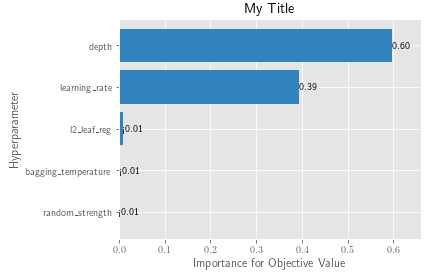

In [43]:
ax = param_importances

# https://stackoverflow.com/a/46906599/5755604
ax.remove()
fig2 = plt.figure()
ax.figure=fig2
fig2.axes.append(ax)
fig2.add_axes(ax)

plt.title("My Title")
plt.tight_layout()

plt.show()

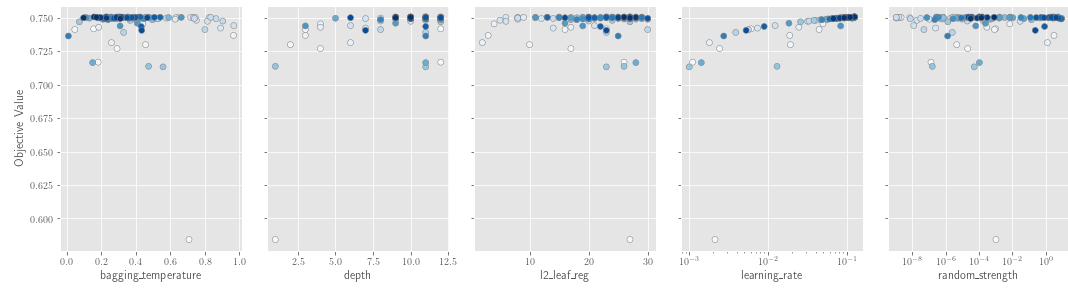

In [44]:
# https://stackoverflow.com/a/46906599/5755604
ax = slices

fig2 = plt.figure(figsize=(16,9))

for i, a in enumerate(ax.flat, start=1):
    a.remove()
    a.figure = fig2
    fig2.axes.append(a)
    fig2.add_axes(a)

plt.tight_layout()

plt.show()

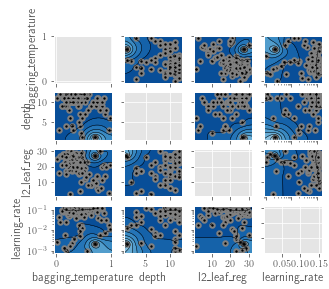

In [45]:
# convert axis array to figure

# https://stackoverflow.com/a/46906599/5755604
ax = contours

fig2 = plt.figure(figsize=(16,9))

for i, a in enumerate(ax.flat, start=1):
    a.remove()
    a.figure = fig2
    # a.set_cmap(cmap)
    fig2.axes.append(a)
    fig2.add_axes(a)

In [46]:
# test relabelling
for a in fig2.axes:
    if a.get_xlabel() == "learning_rate":
        a.set_xlabel("$\lambda$")
    if a.get_ylabel() == "learning_rate":
        a.set_ylabel("$\lambda$")

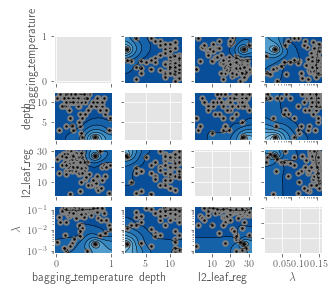

In [47]:
fig2

In [48]:
# visualize learning curves
with open(Path(model_dir,model_name[:-4]+"_training.json"), 'r') as j:
     contents = json.loads(j.read())
    
# extract relevant keys
iterations = contents.get("iterations")
test_metrics = [d['name'] for d in contents['meta']['test_metrics'] ]
test_results = [d['test'] for d in iterations]
learn_metrics = [d['name'] for d in contents['meta']['learn_metrics'] ]
learn_results = [d['learn'] for d in iterations]

metrics_learn = pd.DataFrame(learn_results, columns=learn_metrics).add_prefix("learn_")
metrics_test = pd.DataFrame(test_results, columns=test_metrics).add_prefix("test_")

learning_metrics = pd.concat([metrics_learn, metrics_test], axis=1)

<AxesSubplot:>

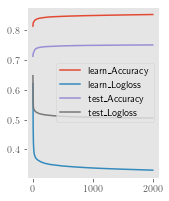

In [50]:
learning_metrics.plot(kind="line", figsize=(6*CM,8*CM), grid=False)